# Training the base model for single intersection traffic light management.
This is my first attempt at sort of like a PoC/prototype for a single intersection.

In [1]:
!python --version

Python 3.9.16


In [3]:
# import libraries
# import torch
import pandas as pd
import numpy as np
import os
# # import cityflow
# import matplotlib.pyplot as plt
# import seaborn as sns
# import torch.nn as nn
# import torch.optim as optim
import copy
# import math

# Environment Definition

In [2]:
class CityFlowEnv:
    '''
        This class is the environment implemented in cityflow for a single intersection.
    '''
    def __init__(self, maxSteps, configPath=os.path.join('generated', 'config.json'), numThreads=1):
        # initializing the cityflow engine
        self.engine = cityflow.Engine(configPath, thread_num=numThreads)
        self.numSteps = 0 # to track how many steps have been taken
        self.maxSteps = maxSteps # the maximum number of steps allowed
    
    def _getState(self):
        '''
            This function returns the state the environment is in right now
        '''
        # get lanecounts
        laneCounts = self.engine.get_lane_vehicle_count()
        # add to a dictionary and return
        cumLaneLenghts = {'road_0_1_0':0, 'road_2_1_2':0, 'road_1_2_3':0, 'road_1_0_1':0}
        for k,v in laneCounts.items():
            if k.startswith('road_0_1_0'):
                cumLaneLenghts['road_0_1_0'] += v
            elif k.startswith('road_2_1_2'):
                cumLaneLenghts['road_2_1_2'] += v
            elif k.startswith('road_1_2_3'):
                cumLaneLenghts['road_1_2_3'] += v
            elif k.startswith('road_1_0_1'):
                cumLaneLenghts['road_1_0_1'] += v
            else:
                continue
        
        return list(cumLaneLenghts.values())
    
    def _getReward(self):
        '''
            This function returns the reward after taking the current state
        '''
        # NOTE: reward will be generated after the action is done, so we need to implement the do_action and simulate traffic for the next 10 seconds
        # after that, calculate the reward
        # get the lanelengths
        laneLengths = -1 * sum(self._getState())
        return laneLengths
    
    def _peformAction(self):
        '''
            This function will take action, which is setting the traffic light to a specific phase.
        '''
        pass
        # set trafficlight phase
        # simulate for the next 10 seconds
        self._step(10)

    def _step(self, t=10):
        '''
            This function steps the environment for the next t seconds.
        '''
        # NOTE TO SELF: rn, the interval is hardcoded to 1 second, same as the config definition, REMEMBER to make this dynamic
        finished = False
        for i in range(t):
            self.numSteps+=1
            if self.numSteps==self.maxSteps:
                finished = True
                break
            self.engine.next_step()
        return finished

    def take_action(self, action, t=10, intersection_id='intersection_1_1'):
        '''
            This is the main callable function for taking a step in the environment. It does the following:
                1. takes the action.
                2. simulates for the next t seconds.
                3. gets the reward
                4. get next state
            Action will be the index of the tl phase for the intersection defined as defined in the roadnet file for that intersection
        '''
        # take action, set the tl phase to the provided index
        self.engine.set_tl_phase(intersection_id, action)
        # run the engine
        finished = self._step(t)
        # get the state
        next_state = self._getState()
        # get the reward
        r = self._getReward()

        return next_state, r, finished
    
    def reset(self):
        '''
            This function resets the environment to the original state.
        '''
        self.engine.reset()
        self.numSteps = 0
        # clearing the replay and the roadnetlog files
        open(os.path.join('generated', 'GeneratedRoadNetLogExpt.json'), 'w').close()
        open(os.path.join('generated', 'GeneratedReplayLogExpt.txt'), 'w').close()
        return self._getState()

## Creating the environment

In [73]:
env = CityFlowEnv(10800)

# Defining the Hyperparameters

In [2]:
# Hyperparameters
PARAM_learning_rate = 0.001
PARAM_gamma = 0.8
PARAM_epsilon = 1.0
PARAM_epsilon_min = 0.01
PARAM_epsilon_decay = 35000
PARAM_batch_size = 64
PARAM_target_update_freq = 10
PARAM_memory_size = 10000
PARAM_episodes = 500
PARAM_TAU = 0.005
# PARAM_device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

# CREATING MODELS

In [3]:
class DQN(nn.Module):
    '''
        This class defines the neural network used for the model.
    '''
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        # creating the layers
        self.layer1 = nn.Linear(input_dim, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        return self.layer3(x)

In [4]:
# defining the input and output dimensions
input_dim, output_dim = 13, 4

### Creating the replay memory

In [5]:
from collections import deque
import random

In [6]:
class ReplayMemory:
    '''
        This class defines the replay memory
    '''
    def __init__(self, bufferSize):
        self.bufferSize = bufferSize
        self.memory = deque(maxlen=self.bufferSize)

    def insert(self, state, action, reward, nextState, done):
        self.memory.append((state, action, reward, nextState, done))
    
    def sample(self, batch_size):
        sampleBatch = random.sample(self.memory, batch_size)
        states, actions, rewards, nextStates, done = zip(*sampleBatch)
        return np.array(states), np.array(actions, dtype=int), np.array(rewards), np.array(nextStates), np.array(done)
    
    def size(self):
        return len(self.memory)

#### Functions for training

In [7]:
def selectAction(state, epsilon):
    '''
        This function selects and returns an action using the epsilon greedy method.
    '''
    # select a random number between 0 and 1
    rNum = random.random()
    # print('Rnum: ', rNum)
    if rNum<epsilon:
        # explore, select a random action
        return random.choice([0,1,2,3])
    else: # exploit, get the best action
        state = torch.tensor(state, device=PARAM_device, dtype=torch.float32).unsqueeze(0)
        qVals = policyNet(state)
        return torch.argmax(qVals).item() # the action that has the highest Q value

#### Training Loop

In [87]:
# copying the epsilon value to use
INUSE_epsilon = copy.deepcopy(PARAM_epsilon)
memory = ReplayMemory(PARAM_memory_size)

In [9]:
policyNet = DQN(input_dim, output_dim)
targetNet = DQN(input_dim, output_dim)
# loading the state dict from policy to target
targetNet.load_state_dict(policyNet.state_dict())
targetNet.eval()

DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=4, bias=True)
)

In [89]:
# optimizer
optimizer = optim.Adam(policyNet.parameters(), lr=PARAM_learning_rate)

In [90]:
# moving the models to gpu
policyNet.to(PARAM_device)
targetNet.to(PARAM_device)

DQN(
  (layer1): Linear(in_features=4, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=4, bias=True)
)

In [91]:
episodeRewards = [] # to store the episode rewards for logging/plotting purposes
stepsDone = 0
# creating a loop for training
for ep in range(PARAM_episodes):
    print('-------------------------------------------------------------')
    print("Episode: ", ep)
    # reset the environment
    state = env.reset()
    epReward = []
    done = False

    # training in the episode
    while not done:
        if stepsDone%250==0:
            print("250 Steps done!, ", stepsDone)
        # select an action and perform it
        action = selectAction(state, INUSE_epsilon)
        nextSt, r, done = env.take_action(action)
        # debug
        # if env.numSteps == 10800:
        #     print("\n!!!10800 steps done!!!\n")

        # store current state, action, reward, next state, done in replay memory
        memory.insert(state, action, r, nextSt, done)

        # update current state to next state
        state = nextSt
        epReward.append(r)

        # update model parameters
        # if memory does not have enough tuples to sample (batch_size), we cant sample so we continue the loop
        if memory.size() < PARAM_batch_size:
            continue
        # else, we train the networks
        # take a sample
        stBatch, aBatch, rBatch, nstBatch, doneBatch = memory.sample(PARAM_batch_size)
        stBatch = torch.tensor(stBatch, device=PARAM_device, dtype=torch.float32)
        aBatch = torch.tensor(aBatch, device=PARAM_device).reshape(-1, aBatch.shape[0])
        rBatch = torch.tensor(rBatch, device=PARAM_device)
        nstBatch = torch.tensor(nstBatch, device=PARAM_device, dtype=torch.float32)
        # getting Q values for current states
        QVals = policyNet(stBatch).gather(1, aBatch)

        # Updating q values using target network
        with torch.no_grad():
            # next state q values using target network
            nextQVals = targetNet(nstBatch).max(1)[0]
            # updating the q values for policy network
            targetQVals = rBatch + PARAM_gamma * nextQVals

        # calculating the loss
        lossFunction = nn.MSELoss()
        loss = lossFunction(QVals, targetQVals.unsqueeze(0))

        # updating model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # updaing the target network periodically
        if ep%PARAM_target_update_freq==0:
            # targetNetStateDict = targetNet.state_dict()
            # policyNetStateDict = policyNet.state_dict()
            # for key in policyNetStateDict:
            #     targetNetStateDict[key] = policyNetStateDict*PARAM_tau
            targetNet.load_state_dict(policyNet.state_dict())
        
        stepsDone+=1

    # decay epsilon after episode is complete
    epsilon = PARAM_epsilon_min + (PARAM_epsilon - PARAM_epsilon_min) * math.exp(-1. * stepsDone/PARAM_epsilon_decay)
    episodeRewards.append(epReward)

-------------------------------------------------------------
Episode:  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 Steps done!,  0
250 St

In [92]:
# need to save everything
import pickle
# saving the models
torch.save(targetNet, "models/TargetNetv2.pth")
torch.save(policyNet, "models/PolicyNetv2.pth")

# saving the lists
with open('models/rewardListv2.pkl', 'wb') as f:
    pickle.dump(episodeRewards, f)

# Loading models for prediction

In [36]:
env = CityFlowEnv(10800)

In [37]:
policyNet = torch.load(os.path.join('models', 'PolicyNet.pth'), weights_only=False)

In [38]:
targetNet = torch.load(os.path.join('models', 'TargetNet.pth'), weights_only=False)

In [58]:
env.reset()

[0, 0, 0, 0]

In [59]:
done = False
state = torch.tensor(env._getState(), device=PARAM_device, dtype=torch.float32) # starting state
rewards = []
step = 1
while not done:
    print("Step: ", step)
    # get the prediction from the model
    QVals = policyNet(state)
    print("QVals: ", QVals)
    # get the best action from QVals
    bestAction = torch.argmax(QVals)
    print("best Action: ", bestAction)
    print('------------------------------')
    # perform the action
    nextState, r, done = env.take_action(bestAction)

    # update the current state
    state = torch.tensor(nextState, device=PARAM_device, dtype=torch.float32)
    rewards.append(r)
    step+=1
    if step==20:
        break

Step:  1
QVals:  tensor([-2509.2739, -2511.6631, -2511.0339, -2510.9023], device='cuda:0',
       grad_fn=<ViewBackward0>)
best Action:  tensor(0, device='cuda:0')
------------------------------
Step:  2
QVals:  tensor([-2540.1638, -2543.0718, -2542.4177, -2542.1948], device='cuda:0',
       grad_fn=<ViewBackward0>)
best Action:  tensor(0, device='cuda:0')
------------------------------
Step:  3
QVals:  tensor([-2540.4495, -2543.3518, -2542.7126, -2542.4890], device='cuda:0',
       grad_fn=<ViewBackward0>)
best Action:  tensor(0, device='cuda:0')
------------------------------
Step:  4
QVals:  tensor([-2541.4441, -2544.3401, -2543.7344, -2543.5154], device='cuda:0',
       grad_fn=<ViewBackward0>)
best Action:  tensor(0, device='cuda:0')
------------------------------
Step:  5
QVals:  tensor([-2541.1831, -2544.0750, -2543.4758, -2543.2632], device='cuda:0',
       grad_fn=<ViewBackward0>)
best Action:  tensor(0, device='cuda:0')
------------------------------
Step:  6
QVals:  tensor([

In [63]:
QVals

tensor([-2568.8936, -2571.7122, -2571.1943, -2571.0959], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [42]:
import pickle

In [44]:
with open('models/rewardList.pkl', 'rb') as f:
    rewardsList = pickle.load(f)

In [53]:
rewardsList[-1]

[-12,
 -13,
 -16,
 -16,
 -23,
 -21,
 -21,
 -19,
 -19,
 -21,
 -18,
 -16,
 -24,
 -22,
 -25,
 -27,
 -30,
 -27,
 -27,
 -24,
 -26,
 -26,
 -24,
 -21,
 -26,
 -26,
 -27,
 -29,
 -35,
 -32,
 -33,
 -36,
 -42,
 -47,
 -41,
 -32,
 -33,
 -30,
 -29,
 -26,
 -35,
 -34,
 -35,
 -32,
 -37,
 -42,
 -38,
 -35,
 -38,
 -36,
 -32,
 -29,
 -32,
 -28,
 -22,
 -22,
 -25,
 -28,
 -27,
 -26,
 -34,
 -36,
 -39,
 -38,
 -40,
 -37,
 -38,
 -34,
 -35,
 -38,
 -34,
 -26,
 -31,
 -28,
 -28,
 -30,
 -36,
 -35,
 -31,
 -31,
 -36,
 -41,
 -34,
 -26,
 -33,
 -31,
 -28,
 -25,
 -28,
 -22,
 -20,
 -19,
 -25,
 -30,
 -30,
 -29,
 -33,
 -34,
 -37,
 -39,
 -44,
 -41,
 -42,
 -38,
 -44,
 -44,
 -39,
 -37,
 -44,
 -38,
 -40,
 -37,
 -42,
 -33,
 -32,
 -28,
 -30,
 -33,
 -29,
 -21,
 -29,
 -30,
 -27,
 -27,
 -36,
 -35,
 -32,
 -30,
 -33,
 -30,
 -27,
 -22,
 -26,
 -24,
 -22,
 -23,
 -24,
 -20,
 -19,
 -21,
 -23,
 -22,
 -22,
 -21,
 -25,
 -21,
 -22,
 -21,
 -29,
 -28,
 -23,
 -26,
 -29,
 -27,
 -25,
 -22,
 -24,
 -25,
 -28,
 -24,
 -29,
 -23,
 -23,
 -24,
 -28,
 -33,
 -30

# THE MODEL PERFORMED EXCEPTIONALLY BAD
Need to check the reason. It only chooses one action always, even if the traffic is pretty much stuck for all lanes except one.
Im thinking these can be the following reasons:
1. Just the setting of the environment, specifically the car spawning rates, because I feel that after a point, it just becomes the same input for every step, for example when the 3 lanes are full. There could also be other reasons for this. I think I should check CoLight's paper and use their metrics, maybe thatll help.
2. Need to check the epsilon decay, if its fast enough, because I have a hunch that right now, the way flows are, random actions can also work. Most probably because the change in flow rates isnt extreme enough, or is more or less similar.
3. Just some straightforward problem/bug in code.
___

Checking for epsilon decay first

In [68]:
INUSE_epsilon = copy.deepcopy(PARAM_epsilon)
epsilonVals = {}
stepsDone = 0
decayList = [1000, 10000, 25000, 35000, 50000, 100000]
for d in decayList:
    print(d)
    epsilons = []
    stepsDone = 0
    for ep in range(PARAM_episodes):
        for i in range(1080):
            stepsDone+=1
        # decaying epsilon
        epsilon = PARAM_epsilon_min + (PARAM_epsilon - PARAM_epsilon_min) * math.exp(-1. * stepsDone/d)
        # print('Epsilon: ', epsilon, '|| Episode: ', ep)
        epsilons.append(epsilon)
    epsilonVals[d] = epsilons

1000
10000
25000
35000
50000
100000


In [69]:
epsilonVals[35000]

[0.969917938684749,
 0.9407499484937146,
 0.9124682545343663,
 0.8850459258798506,
 0.858456849924317,
 0.8326757075174807,
 0.8076779488547449,
 0.7834397700999245,
 0.7599380907183086,
 0.73715053149848,
 0.7150553932419601,
 0.6936316361003912,
 0.6728588595405757,
 0.652717282918296,
 0.6331877266424174,
 0.6142515939113375,
 0.5958908530043889,
 0.5780880201113355,
 0.5608261426836095,
 0.5440887832914363,
 0.5278600039714758,
 0.5121243510500757,
 0.49686684042768275,
 0.48207294331040185,
 0.46772857237511434,
 0.4538200683549825,
 0.4403341870325648,
 0.42725808662815845,
 0.4145793155713578,
 0.4022858006441862,
 0.39036583548450865,
 0.3788080694387797,
 0.3676014967535102,
 0.3567354460951621,
 0.34619957038848975,
 0.3359838369636538,
 0.3260785180027231,
 0.31647418127646887,
 0.3071616811626304,
 0.29813214993709775,
 0.2893769893297211,
 0.280887862336704,
 0.2726566852817847,
 0.2646756201186461,
 0.2569370669672232,
 0.2494336568768027,
 0.24215824480902215,
 0.2351039

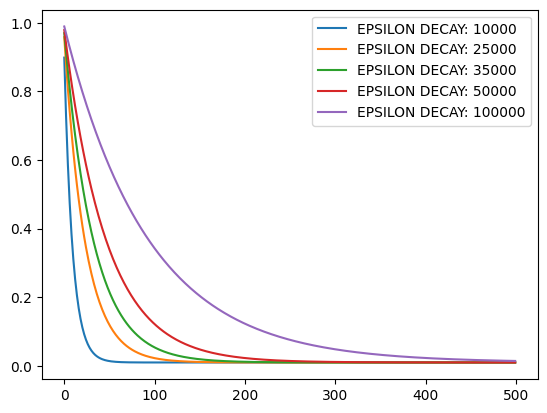

In [70]:
for k,v in epsilonVals.items():
    if k==1000:
        continue
    plt.plot(v, label=f'EPSILON DECAY: {k}')
plt.legend()
plt.show()

In [56]:
PARAM_epsilon_decay = 35000
PARAM_epsilon, PARAM_epsilon_min, PARAM_epsilon_decay

(1.0, 0.01, 35000)

# Running the new model

In [16]:
env = CityFlowEnv(10800)

In [11]:
policyNet = torch.load(os.path.join('models', 'PolicyNetv2.pth'), weights_only=False)

In [12]:
targetNet = torch.load(os.path.join('models', 'TargetNetv2.pth'), weights_only=False)

In [34]:
# env._getState()
env.reset()

[0, 0, 0, 0]

In [39]:
done = False
state = torch.tensor(env._getState(), device=PARAM_device, dtype=torch.float32) # starting state
rewards = []
step = 1
while not done:
    print("Step: ", step)
    # get the prediction from the model
    QVals = policyNet(state)
    print("QVals: ", QVals)
    # get the best action from QVals
    bestAction = QVals.argmax(dim=0).view(1,1).cpu().numpy()
    print("best Action: ", bestAction)
    # perform the action
    nextState, r, done = env.take_action(bestAction)
    print('State: ', state.cpu().numpy())
    print('------------------------------')

    # update the current state
    state = torch.tensor(nextState, device=PARAM_device, dtype=torch.float32)
    rewards.append(r)
    step+=1
    if step==5:
        break
    # break

Step:  1
QVals:  tensor([-2288.4387, -2281.2598, -2284.5039, -2288.8259], device='cuda:0',
       grad_fn=<ViewBackward0>)
best Action:  [[1]]
State:  [3. 3. 3. 3.]
------------------------------
Step:  2
QVals:  tensor([-2288.7825, -2281.6006, -2284.8423, -2289.1736], device='cuda:0',
       grad_fn=<ViewBackward0>)
best Action:  [[1]]
State:  [4. 3. 3. 3.]
------------------------------
Step:  3
QVals:  tensor([-2289.6953, -2282.5120, -2285.7534, -2290.0994], device='cuda:0',
       grad_fn=<ViewBackward0>)
best Action:  [[1]]
State:  [6. 3. 4. 3.]
------------------------------
Step:  4
QVals:  tensor([-2289.8962, -2282.7192, -2285.9634, -2290.2983], device='cuda:0',
       grad_fn=<ViewBackward0>)
best Action:  [[1]]
State:  [7. 4. 4. 3.]
------------------------------


/tmp/ipykernel_1160/2679371309.py:76: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  self.engine.set_tl_phase(intersection_id, action)


In [37]:
st = torch.tensor([3,3,3,3], dtype=torch.float32, device=PARAM_device)
st

tensor([3., 3., 3., 3.], device='cuda:0')

In [38]:
targetNet(st)

tensor([-2306.7148, -2293.3281, -2304.5603, -2307.8433], device='cuda:0',
       grad_fn=<ViewBackward0>)

In [36]:
state

tensor([3., 3., 3., 3.], device='cuda:0')

# Even with the epsilon decay _bug_ fixed, it didnt make any difference. I have two ways of going on from here.
1. Change the environment, like the flow, and train in it, to see if anything changes, maybe use GPLight's flow data.
2. Go forward directly to the nxn grid. As for a single intersection, this might not makes sense.
___
Im going forward with number 1 for now. And then see what happens. Ill maybe use GPLight's flow, and even reward function.

#### Scratch that, going with number 2

Testing the env without any RL control to see if its working as expected.

In [3]:
env = cityflow.Engine("generated/config.json")

In [6]:
for i in range(3600):
    env.next_step()

In [30]:
for i in range(10):
    env.next_step()

In [19]:
# 
env.get_lane_vehicle_count(), env.get_lane_waiting_vehicle_count()

({'road_0_1_0_0': 32,
  'road_0_1_0_1': 31,
  'road_0_1_0_2': 1,
  'road_1_0_1_0': 1,
  'road_1_0_1_1': 1,
  'road_1_0_1_2': 1,
  'road_1_1_0_0': 2,
  'road_1_1_0_1': 1,
  'road_1_1_0_2': 1,
  'road_1_1_1_0': 1,
  'road_1_1_1_1': 1,
  'road_1_1_1_2': 1,
  'road_1_1_2_0': 1,
  'road_1_1_2_1': 1,
  'road_1_1_2_2': 1,
  'road_1_1_3_0': 1,
  'road_1_1_3_1': 1,
  'road_1_1_3_2': 1,
  'road_1_2_3_0': 1,
  'road_1_2_3_1': 1,
  'road_1_2_3_2': 1,
  'road_2_1_2_0': 33,
  'road_2_1_2_1': 31,
  'road_2_1_2_2': 1},
 {'road_0_1_0_0': 28,
  'road_0_1_0_1': 27,
  'road_0_1_0_2': 0,
  'road_1_0_1_0': 0,
  'road_1_0_1_1': 0,
  'road_1_0_1_2': 0,
  'road_1_1_0_0': 0,
  'road_1_1_0_1': 0,
  'road_1_1_0_2': 0,
  'road_1_1_1_0': 0,
  'road_1_1_1_1': 0,
  'road_1_1_1_2': 0,
  'road_1_1_2_0': 0,
  'road_1_1_2_1': 0,
  'road_1_1_2_2': 0,
  'road_1_1_3_0': 0,
  'road_1_1_3_1': 0,
  'road_1_1_3_2': 0,
  'road_1_2_3_0': 0,
  'road_1_2_3_1': 0,
  'road_1_2_3_2': 0,
  'road_2_1_2_0': 29,
  'road_2_1_2_1': 26,
  'r

The flow file seems to work fine.

### IMPORTANT
It does not seem that any kind of normalization is being used here. And the current state is, current traffic light and number of cars in each lane. Wonder what is it that Im doing wrong here. Ill start off by doing the following:
1. Change the state definition to include the phase.
2. Change the reward function.
3. Finally Ill train two different models, one with normalization, one without, and see what works.

__I HOPE IT WORKS BECAUSE MY IMPOSTOR SYNDROME IS KICKING IN BIG TIME__

Creating the new reward function

In [31]:
# we need to get the P_i for each of the 12 directions
directions = [('road_0_1_0_0', 'road_1_1_1_0'), # left
              ('road_1_0_1_0', 'road_1_1_2_0'), # left
              ('road_2_1_2_0', 'road_1_1_3_0'), # left
              ('road_1_2_3_0', 'road_1_1_0_0'), # left
              ('road_0_1_0_1', 'road_1_1_0_1'), # straight
              ('road_1_0_1_1', 'road_1_1_1_1'), # straight
              ('road_2_1_2_1', 'road_1_1_2_1'), # straight
              ('road_1_2_3_1', 'road_1_1_3_1'), # straight
              ('road_0_1_0_2', 'road_1_1_3_2'), # right
              ('road_1_0_1_2', 'road_1_1_0_2'), # right
              ('road_2_1_2_2', 'road_1_1_1_2'), # right
              ('road_1_2_3_2', 'road_1_1_2_2') # right
              ]

capacity = 40 # capacity for each lane

In [32]:
r = 0
for d in directions:
    # calculaing r_i for each direction
    nIn = env.get_lane_waiting_vehicle_count()[d[0]] # waiting vics in incoming lane
    nOut = env.get_lane_waiting_vehicle_count()[d[1]] # waiting vics in outgoing lane
    print(nIn, nOut)
    r_i = -1 * nIn * (1 - (nOut/capacity))
    r += r_i

21 0
1 0
30 0
1 0
19 0
1 0
27 0
0 0
0 0
0 0
0 0
0 0


In [33]:
r

-100.0

### New env

In [5]:
class PressureEnv:
    '''
        This class is the environment implemented in cityflow for a single intersection.
    '''
    def __init__(self, maxSteps, configPath=os.path.join('generated', 'config.json'), numThreads=1):
        # initializing the cityflow engine
        self.engine = cityflow.Engine(configPath, thread_num=numThreads)
        self.numSteps = 0 # to track how many steps have been taken
        self.maxSteps = maxSteps # the maximum number of steps allowed
        self.directions = [('road_0_1_0_0', 'road_1_1_1_0'), # left
              ('road_1_0_1_0', 'road_1_1_2_0'), # left
              ('road_2_1_2_0', 'road_1_1_3_0'), # left
              ('road_1_2_3_0', 'road_1_1_0_0'), # left
              ('road_0_1_0_1', 'road_1_1_0_1'), # straight
              ('road_1_0_1_1', 'road_1_1_1_1'), # straight
              ('road_2_1_2_1', 'road_1_1_2_1'), # straight
              ('road_1_2_3_1', 'road_1_1_3_1'), # straight
              ('road_0_1_0_2', 'road_1_1_3_2'), # right
              ('road_1_0_1_2', 'road_1_1_0_2'), # right
              ('road_2_1_2_2', 'road_1_1_1_2'), # right
              ('road_1_2_3_2', 'road_1_1_2_2') # right
              ]
        self.incoming = [t[0] for t in self.directions]
        self.capacity = 40 # capacity of the lanes
    
    def _getState(self, currTLPhase):
        '''
            This function returns the state the environment is in right now
        '''
        # get lanecounts
        laneCounts = self.engine.get_lane_vehicle_count()
        # add to a dictionary and return
        stArray = []
        cumLaneLenghts = {'road_0_1_0':0, 'road_2_1_2':0, 'road_1_2_3':0, 'road_1_0_1':0}
        for k,v in laneCounts.items():
            if k in self.incoming:
                stArray.append(v)
        # appending the current phase
        stArray.append(currTLPhase)
        
        return stArray
    
    def _getReward(self):
        '''
            This function returns the reward after taking the current state
        '''
        # NOTE: reward will be generated after the action is done, so we need to implement the do_action and simulate traffic for the next 10 seconds
        # after that, calculate the reward
        # get the lanelengths
        r = 0
        vicCounts = self.engine.get_lane_waiting_vehicle_count()
        for d in self.directions:
            # calculate the number of incoming and outgoing vehicles
            nIn = vicCounts[d[0]]
            nOut = vicCounts[d[1]]
            r_i = -1 * nIn * (1 - (nOut/self.capacity))
            r += r_i
        return r
    
    def _peformAction(self):
        '''
            This function will take action, which is setting the traffic light to a specific phase.
        '''
        pass
        # set trafficlight phase
        # simulate for the next 10 seconds
        self._step(10)

    def _step(self, t=10):
        '''
            This function steps the environment for the next t seconds.
        '''
        # NOTE TO SELF: rn, the interval is hardcoded to 1 second, same as the config definition, REMEMBER to make this dynamic
        finished = False
        for i in range(t):
            self.numSteps+=1
            if self.numSteps==self.maxSteps:
                finished = True
                break
            self.engine.next_step()
        return finished

    def take_action(self, action, t=10, intersection_id='intersection_1_1'):
        '''
            This is the main callable function for taking a step in the environment. It does the following:
                1. takes the action.
                2. simulates for the next t seconds.
                3. gets the reward
                4. get next state
            Action will be the index of the tl phase for the intersection defined as defined in the roadnet file for that intersection
        '''
        # take action, set the tl phase to the provided index
        self.engine.set_tl_phase(intersection_id, action)
        # run the engine
        finished = self._step(t)
        # get the state
        next_state = self._getState(action)
        # get the reward
        r = self._getReward()

        return next_state, r, finished
    
    def reset(self,currTLPhase):
        '''
            This function resets the environment to the original state.
        '''
        self.engine.reset()
        self.numSteps = 0
        # clearing the replay and the roadnetlog files
        open(os.path.join('generated', 'GeneratedRoadNetLogExpt.json'), 'w').close()
        open(os.path.join('generated', 'GeneratedReplayLogExpt.txt'), 'w').close()
        return self._getState(currTLPhase)

In [9]:
env = PressureEnv(maxSteps=3600)

#### Before starting training, time to check which one would be a good decay rate

In [4]:
PARAM_episodes

500

In [8]:
import math
import matplotlib.pyplot as plt

In [6]:
INUSE_epsilon = copy.deepcopy(PARAM_epsilon)
epsilonVals = {}
stepsDone = 0
decayList = [1000, 10000, 25000, 35000, 50000, 100000]
for d in decayList:
    print(d)
    epsilons = []
    stepsDone = 0
    for ep in range(500):
        for i in range(360):
            stepsDone+=1
        # decaying epsilon
        epsilon = PARAM_epsilon_min + (PARAM_epsilon - PARAM_epsilon_min) * math.exp(-1. * stepsDone/d)
        # print('Epsilon: ', epsilon, '|| Episode: ', ep)
        epsilons.append(epsilon)
    epsilonVals[d] = epsilons

1000
10000
25000
35000
50000
100000


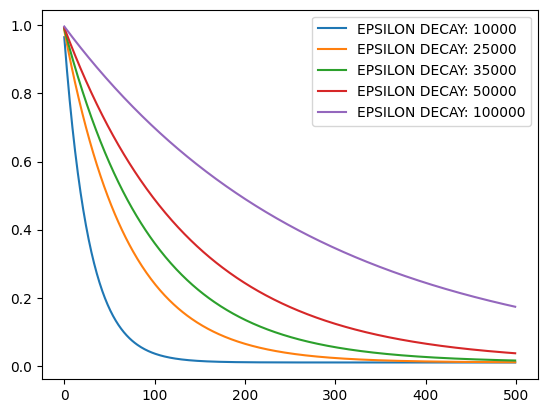

In [9]:
for k,v in epsilonVals.items():
    if k==1000:
        continue
    plt.plot(v, label=f'EPSILON DECAY: {k}')
plt.legend()
plt.show()

In [25]:
# 50k looks okay
PARAM_epsilon_decay = 50000

There was another bug that I noticed, the wrong epsilon variable was being used or updated. I need to change that too. Im going to now train with the new environment. Please make it work GOD.

In [26]:
# copying the epsilon value to use
INUSE_epsilon = copy.deepcopy(PARAM_epsilon)
# initializing the memory
memory = ReplayMemory(PARAM_memory_size)

In [27]:
# Declaring the networks
policyNet = DQN(input_dim, output_dim)
targetNet = DQN(input_dim, output_dim)
# loading the state dict from policy to target so that they have the same starting weights
targetNet.load_state_dict(policyNet.state_dict())

<All keys matched successfully>

In [28]:
# optimizer
optimizer = optim.Adam(policyNet.parameters(), lr=PARAM_learning_rate)

In [29]:
# moving the models to gpu
policyNet.to(PARAM_device)
targetNet.to(PARAM_device)

DQN(
  (layer1): Linear(in_features=13, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=4, bias=True)
)

In [30]:
episodeRewards = [] # to store the episode rewards for logging/plotting purposes
stepsDone = 0
# creating a loop for training
for ep in range(PARAM_episodes):
    print('###-'* 30)
    print("Episode: ", ep)
    print("Epsilon Used for the episode: ", INUSE_epsilon)
    # reset the environment
    state = env.reset(0)
    epReward = []
    done = False

    # training in the episode
    while not done:
        # if stepsDone%250==0:
        #     print("250 Steps done!, ", stepsDone)
        # recording the previous action
        # recording previous action the previous TL phase
        # print("stepsDone: ", stepsDone)
        if stepsDone==0:
            prevAction = 0
        else:
            prevAction = action
        # print("Prev action: ", prevAction)
        # select an action and perform it
        action = selectAction(state, INUSE_epsilon)
        stepsDone+=1
        # print("ACTION SELECTED: ", action)
        nextSt, r, done = env.take_action(action = action)
        # print("nextSt: ", nextSt)
        # debug
        # if env.numSteps == 10800:
        #     print("\n!!!10800 steps done!!!\n")

        # store current state, action, reward, next state, done in replay memory
        memory.insert(state, action, r, nextSt, done)

        # update current state to next state
        state = nextSt
        epReward.append(r)

        # update model parameters
        # if memory does not have enough tuples to sample (batch_size), we cant sample so we continue the loop
        # print('Memory size: ', memory.size())
        if memory.size() < PARAM_batch_size:
            continue
        # else, we train the networks
        # take a sample
        stBatch, aBatch, rBatch, nstBatch, doneBatch = memory.sample(PARAM_batch_size)
        stBatch = torch.tensor(stBatch, device=PARAM_device, dtype=torch.float32)
        aBatch = torch.tensor(aBatch, device=PARAM_device).unsqueeze(1)
        rBatch = torch.tensor(rBatch, device=PARAM_device, dtype=torch.float32)
        nstBatch = torch.tensor(nstBatch, device=PARAM_device, dtype=torch.float32)
        # getting Q values for current states
        QVals = policyNet(stBatch).gather(1, aBatch)

        # Updating q values using target network
        with torch.no_grad():
            # next state q values using target network
            nextQVals = targetNet(nstBatch).max(1)[0]
            # updating the q values for policy network
            targetQVals = rBatch + PARAM_gamma * nextQVals

        # calculating the loss
        lossFunction = nn.SmoothL1Loss()
        loss = lossFunction(QVals, targetQVals.unsqueeze(1))

        # updating model weights
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # updaing the target network periodically
        if ep%PARAM_target_update_freq==0:
            # targetNetStateDict = targetNet.state_dict()
            # policyNetStateDict = policyNet.state_dict()
            # for key in policyNetStateDict:
            #     targetNetStateDict[key] = policyNetStateDict*PARAM_tau
            targetNet.load_state_dict(policyNet.state_dict())
        

    # decay epsilon after episode is complete
    INUSE_epsilon = PARAM_epsilon_min + (PARAM_epsilon - PARAM_epsilon_min) * math.exp(-1. * stepsDone/PARAM_epsilon_decay)
    episodeRewards.append(epReward)

    # printing training stats
    print("EPISODE COMPLETE")
    print(f"min_reward: {min(epReward)} || max_reward: {max(epReward)} || total_reward: {sum(epReward)} || average_reward: {np.mean(epReward)}")

###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-
Episode:  0
Epsilon Used for the episode:  1.0
EPISODE COMPLETE
min_reward: -140.0 || max_reward: 0.0 || total_reward: -28933.0 || average_reward: -80.36944444444444
###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-
Episode:  1
Epsilon Used for the episode:  0.9928975993247753
EPISODE COMPLETE
min_reward: -146.0 || max_reward: 0.0 || total_reward: -30206.0 || average_reward: -83.90555555555555
###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-
Episode:  2
Epsilon Used for the episode:  0.9858461522812185
EPISODE COMPLETE
min_reward: -142.0 || max_reward: 0.0 || total_reward: -29424.0 || average_reward: -81.73333333333333
###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-###-#

In [31]:
# saving the models
# need to save everything
import pickle
# saving the models
torch.save(targetNet, "models/TargetNetv4.pth")
torch.save(policyNet, "models/PolicyNetv4.pth")

# saving the lists
with open('models/rewardListv4.pkl', 'wb') as f:
    pickle.dump(episodeRewards, f)

# Debugging Shenanigans

NOTE TO SELF: Before re-running this tomorrow, check that all the shapes are consistent, and that the gather function is working correctly, only then, run it. I have fixed some tonight, such as:
- current phase for the next state is set to be equal to the action, instead of previous phase (which I had done by mistake) [DONE]
- Gather wasnt giving correct Q Values due to shape issues, that should have been fixed, if not, refer the cell below for the correct aBatch shape and the correct gather parameters. [DONE]
- Make sure that for the loss function, the QVals and TargetQVals have the same shape, it could be 64,1 or 1,64 or whatever, its fine as long as their shape is the same. [DONE]
- Try using SmoothL1Loss instead of MSE. Apparantly it is supposed to be more stable. [DONE]

In [17]:
stBatch, aBatch, rBatch, nstBatch, doneBatch = memory.sample(PARAM_batch_size)
stBatch = torch.tensor(stBatch, device=PARAM_device, dtype=torch.float32)
aBatch = torch.tensor(aBatch, device=PARAM_device).unsqueeze(1)
rBatch = torch.tensor(rBatch, device=PARAM_device, dtype=torch.float32)
nstBatch = torch.tensor(nstBatch, device=PARAM_device, dtype=torch.float32)

In [ ]:
aBatch.shape

torch.Size([64, 1])

In [21]:
aBatch

tensor([[3],
        [0],
        [1],
        [1],
        [2],
        [0],
        [1],
        [2],
        [0],
        [3],
        [2],
        [2],
        [2],
        [3],
        [3],
        [1],
        [0],
        [1],
        [3],
        [2],
        [1],
        [1],
        [2],
        [3],
        [3],
        [0],
        [1],
        [3],
        [0],
        [2],
        [2],
        [1],
        [2],
        [0],
        [1],
        [3],
        [2],
        [1],
        [2],
        [3],
        [1],
        [2],
        [0],
        [0],
        [1],
        [0],
        [1],
        [2],
        [1],
        [0],
        [3],
        [2],
        [3],
        [1],
        [1],
        [3],
        [1],
        [3],
        [1],
        [3],
        [3],
        [1],
        [1],
        [2]], device='cuda:0')

In [19]:
q = policyNet(stBatch)
q.shape

torch.Size([64, 4])

In [22]:
qv = q.gather(1, aBatch)
# qv.shape
qv

tensor([[ -772.4964],
        [-2856.6091],
        [ -612.6323],
        [-3285.7737],
        [ -479.3011],
        [-3018.7864],
        [-3210.8848],
        [-1734.7593],
        [ -377.2107],
        [ -663.1656],
        [ -482.6180],
        [ -695.5036],
        [-3102.1565],
        [-3638.4099],
        [-2906.9006],
        [-3294.7976],
        [-2865.6377],
        [-3124.0583],
        [ -717.2283],
        [-2441.7175],
        [ -467.0646],
        [-2965.3010],
        [-3162.9597],
        [ -719.0084],
        [-3320.7771],
        [-2837.5127],
        [-2687.4963],
        [-3239.9607],
        [-3052.2825],
        [ -512.8585],
        [-3113.2363],
        [-3402.0400],
        [-3154.1001],
        [ -769.5070],
        [-3139.3794],
        [-3266.2278],
        [-2491.9050],
        [ -810.2480],
        [-3139.6357],
        [ -629.4410],
        [-2956.2581],
        [-3432.9868],
        [ -551.6158],
        [-2873.3030],
        [-3286.9487],
        [-

In [20]:
q
# qv.shape

tensor([[ -739.4864,  -762.3033,  -769.9965,  -772.4964],
        [-2856.6091, -2933.9246, -3021.2268, -3030.1731],
        [ -595.3767,  -612.6323,  -621.8085,  -626.0457],
        [-3197.9443, -3285.7737, -3380.2305, -3391.0081],
        [ -464.1333,  -480.8954,  -479.3011,  -482.9185],
        [-3018.7864, -3103.8247, -3185.9072, -3198.1831],
        [-3125.9009, -3210.8848, -3305.6948, -3314.5444],
        [-1656.0590, -1706.2531, -1734.7593, -1747.5022],
        [ -377.2107,  -390.0788,  -392.0471,  -394.1255],
        [ -638.7922,  -662.3054,  -657.1705,  -663.1656],
        [ -463.7555,  -479.2653,  -482.6180,  -486.1859],
        [ -665.9645,  -685.6186,  -695.5036,  -701.2598],
        [-2935.6384, -3014.3857, -3102.1565, -3113.1453],
        [-3430.6130, -3523.7234, -3628.7434, -3638.4099],
        [-2747.3538, -2825.8904, -2894.1951, -2906.9006],
        [-3206.4062, -3294.7976, -3387.5488, -3399.2417],
        [-2865.6377, -2948.1169, -3015.4456, -3031.7034],
        [-3041

In [24]:
QVals.shape, targetQVals.unsqueeze(1).shape

(torch.Size([64, 1]), torch.Size([64, 1]))

In [281]:
# QVals.shape, targetQVals.unsqueeze(1).shape
QValsR = QVals.reshape(64,1)

In [36]:
t = torch.tensor(env._getState(0), dtype=torch.float32, device=PARAM_device)
t

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')

In [38]:
with torch.no_grad():
    q = policyNet(t)
    a = torch.argmax(q).item()

In [39]:
a, q

(1, tensor([2542.5510, 2600.9631, 2471.1885, 2534.9917], device='cuda:0'))

In [40]:
policyNet(t)

tensor([2542.5510, 2600.9631, 2471.1885, 2534.9917], device='cuda:0',
       grad_fn=<ViewBackward0>)

# Trying to make predictions

After making the changes *hopefully (fingers crossed)* it works. Please GOD.

In [6]:
env = PressureEnv(maxSteps=3600)

In [ ]:
# DO NOT RUN
# policyNet.eval()

DQN(
  (layer1): Linear(in_features=13, out_features=128, bias=True)
  (layer2): Linear(in_features=128, out_features=128, bias=True)
  (layer3): Linear(in_features=128, out_features=4, bias=True)
)

In [7]:
import pickle
policyNet = torch.load('models/PolicyNetv6.pth', weights_only=False)
targetNet = torch.load('models/TargetNetv6.pth', weights_only=False)

In [8]:
done = False
state = env._getState(0)
# prevAct = 0
rewards = []
step = 0
while not done:
    print("Step: ", step)
    state_tensor = torch.tensor(state, dtype=torch.float32, device=PARAM_device).unsqueeze(0)
    # get the prediction from the model
    with torch.no_grad():
        QVals = policyNet(state_tensor)
        print("QVals: ", QVals)
        # get the best action from QVals
        bestAction = torch.argmax(QVals).item()
        print("best Action: ", bestAction)
    # perform the action
    nextState, r, done = env.take_action(bestAction)
    print("Done:", done)
    # print('State: ', state.cpu().numpy())
    print('------------------------------')

    # update the current state
    state = nextState
    rewards.append(r)
    step+=1
    # if step==5:
    #     break
    # break
    # prevAct = bestAction

Step:  0
QVals:  tensor([[-15.5755, -15.8600, -18.2971, -19.3286]], device='cuda:0')
best Action:  0
Done: False
------------------------------
Step:  1
QVals:  tensor([[-19.9135, -21.5175, -21.2117, -19.0056]], device='cuda:0')
best Action:  3
Done: False
------------------------------
Step:  2
QVals:  tensor([[-24.9992, -24.9981, -24.7322, -38.1167]], device='cuda:0')
best Action:  2
Done: False
------------------------------
Step:  3
QVals:  tensor([[-27.3267, -26.1677, -28.5961, -29.1412]], device='cuda:0')
best Action:  1
Done: False
------------------------------
Step:  4
QVals:  tensor([[-27.5502, -32.4305, -29.5893, -27.7698]], device='cuda:0')
best Action:  0
Done: False
------------------------------
Step:  5
QVals:  tensor([[-28.5513, -28.1850, -26.3112, -25.9624]], device='cuda:0')
best Action:  3
Done: False
------------------------------
Step:  6
QVals:  tensor([[-28.6608, -26.8911, -25.6776, -32.4396]], device='cuda:0')
best Action:  2
Done: False
-----------------------

In [68]:
env.numSteps

5

In [71]:
env.reset(0)
done = False
while not done:
    ns, r, done = env.take_action(0)

#### Things to note: V5.
Here are a bunch of things that I understood from the V5. See OneNote for that.
___
## Trying to analyze the model's performance, basically things such as average travel time, visually looking at the performance of the model in the frontend etc.

- Looking at average travel time.

In [9]:
env.engine.get_average_travel_time()

944.0625

Creating an env without rl with 10 seconds durations.

In [8]:
nonRLEngine = cityflow.Engine('generated/configManual.json')

In [9]:
# running for 3600 seconds
for i in range(3600):
    nonRLEngine.next_step()

In [29]:
nonRLEngine.get_average_travel_time()

999.2485313315927

In [15]:
policyNet(torch.tensor(env._getState(0), dtype=torch.float32, device=PARAM_device))

tensor([-579.2397, -551.5745, -571.1451, -565.6125], device='cuda:0',
       grad_fn=<ViewBackward0>)